<a href="https://colab.research.google.com/github/astrrr/Image-Processing-Lab/blob/main/Activity9_imageprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [289]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import glob
from keras.preprocessing import image
from sklearn.cluster import KMeans
from skimage.feature import hog
from skimage import exposure
from skimage.measure import label
import pandas as pd


In [290]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 9.1 Prepare Histogram of Gradient(HoG) feature 

* 9.1.1 VIEW HOG FEATURE OF IMAGE

In [291]:
#Load main images in dataset
# ลองอย่างน้อย 4 รูป เพื่อหาพารามิเตอร์ที่ดีที่สุด เช่น block_size (ขนาดบล็อก), stride (ระยะขยับ sliding window)
filenames= glob.glob ('/content/drive/MyDrive/image_processing_lab9/*/*/*')
img = cv2.imread('/content/drive/MyDrive/image_processing_lab9/Animals/Cats/cat10.jpg')
img = cv2.resize(img, (80,80), interpolation= cv2.INTER_AREA)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

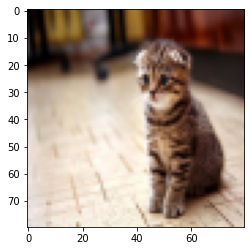

In [292]:
plt.imshow(img)

In [293]:
# Create Image Feature
# Bluring image to reduce noise
blur = cv2.GaussianBlur(img,(5,5),0) #Gaussian Filtering

# Calculate HoG of image
fd, hog_image = hog(blur, orientations=9, 
                    pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), 
                    visualize=True, 
                    multichannel=True)

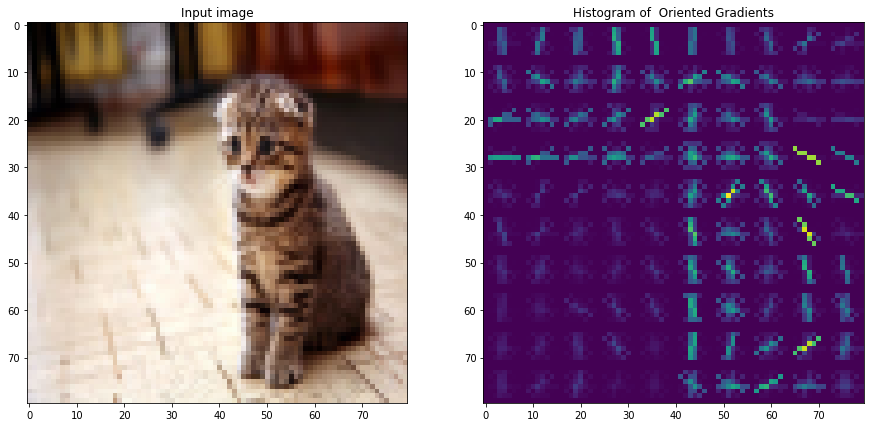

In [294]:
fig = plt.figure(figsize=(15,15))

fig.add_subplot(121)
plt.title('Input image')
plt.imshow(img)

fig.add_subplot(122)
plt.title('Histogram of  Oriented Gradients')
plt.imshow(hog_image)

plt.show()

* 9.1.2 PREPARE HOG FEATURE OF SUBIMAGES

In [295]:
#Define block size for subimage
height = 60
width = 20
Block_size = (height, width) # ลองอย่างน้อย 3 ค่า เช่น (40,20), (40, 30), (60, 20), (60,30), (60,40)

# Define stride (ระยะขยับ pixel เพื่อท า sliding window เพื่อค านวณ HoG)
tx = 1
ty = 1
Stride = (tx, ty)

In [296]:
# Define Sliding window position of row, column (Top left position)
posRow = np.arange(0, img.shape[0] - Block_size[0]+1, Stride[0])
posCol = np.arange(0, img.shape[1] - Block_size[1]+1, Stride[1])

In [297]:
print(posCol)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60]


In [298]:
print(posRow)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [299]:
# Create subimage feature
# Calculate HoG of each subimage in Sliding window
hogfeatures = []
hog_image_list = []

for i in posRow:
  for j in posCol:
    startH = posRow[i]
    endH = posRow[i] + Block_size[0]
    startW = posCol[j]
    endW = posCol[j] + Block_size[1]
    subImg = img[ startH:endH , startW:endW ,:]
    blur = cv2.GaussianBlur(subImg,(5,5),0) #Gaussian Filtering
    fd, hog_image = hog(blur, orientations=9, 
                        pixels_per_cell=(4, 4),
                        cells_per_block=(2, 2), 
                        visualize=True, 
                        multichannel=True)

    hogfeatures.append(fd)
    hog_image_list.append(hog_image)

In [300]:
len(hog_image_list)

1281

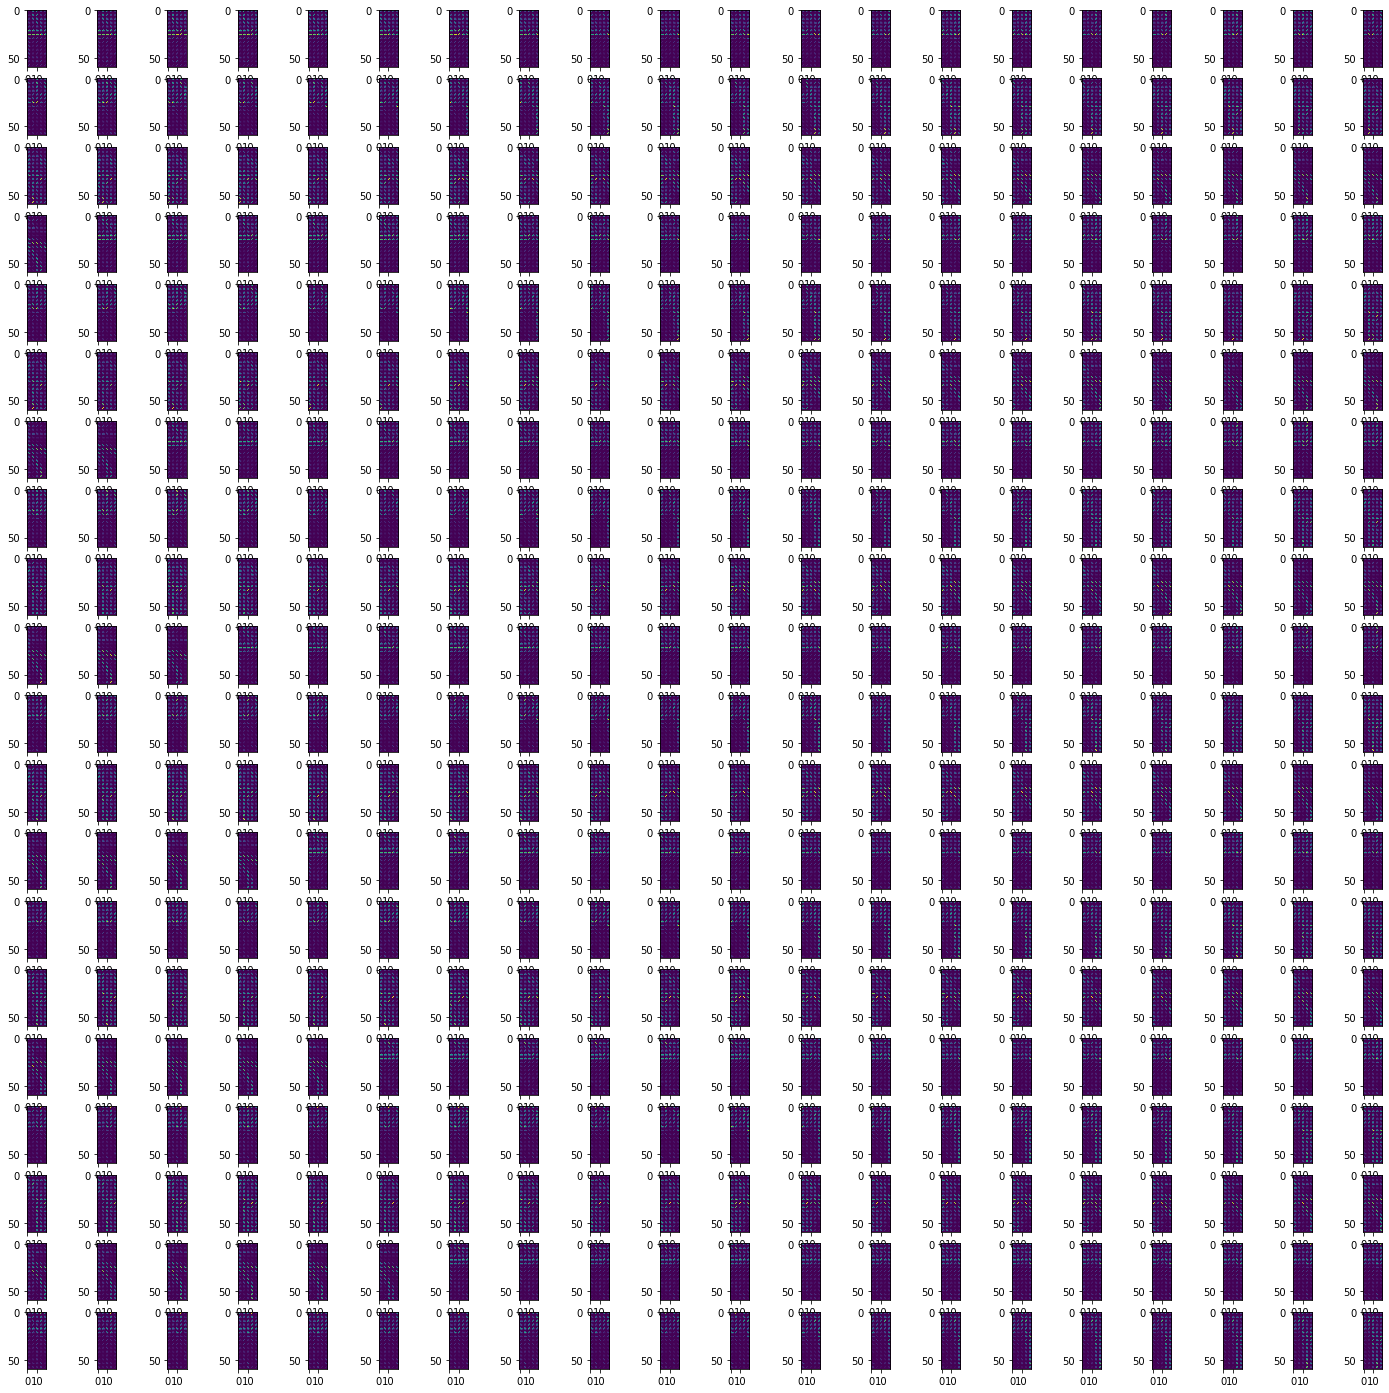

In [301]:
r = 20
c = 20

fig = plt.figure(figsize=(25,25))
for i in range(400):
  fig.add_subplot(r,c,i+1)
  plt.imshow(hog_image_list[i])
plt.show()


In [302]:
print(hogfeatures)

[array([0.04430376, 0.01781269, 0.02253147, ..., 0.        , 0.        ,
       0.        ]), array([0.21356858, 0.        , 0.0105976 , ..., 0.        , 0.03656358,
       0.        ]), array([0.28915976, 0.        , 0.00425973, ..., 0.025696  , 0.        ,
       0.        ]), array([0.35289751, 0.        , 0.        , ..., 0.02322439, 0.        ,
       0.        ]), array([0.39381797, 0.        , 0.        , ..., 0.31388109, 0.        ,
       0.        ]), array([0.39479122, 0.06547966, 0.        , ..., 0.27229023, 0.27229023,
       0.        ]), array([0.3614779 , 0.09477334, 0.01695928, ..., 0.1332823 , 0.30526191,
       0.        ]), array([0.33956412, 0.04401511, 0.04899964, ..., 0.        , 0.28632479,
       0.28632479]), array([0.37637918, 0.        , 0.        , ..., 0.        , 0.28746357,
       0.28746357]), array([0.36296111, 0.        , 0.        , ..., 0.06740691, 0.31052676,
       0.18860366]), array([0.31369248, 0.        , 0.        , ..., 0.06702471, 0.2651808

# 9.2 Image Segmentation Using K-mean clustering (Foreground (FG), Backgrou(BG))

* 9.2.1 K-MEAN CLUSTERING

In [303]:
# Clean feature if NA fillna(0)
df = pd.DataFrame(hogfeatures)

In [304]:
df

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
0,0.044304,0.017813,0.022531,0.000000,0.035847,0.021502,0.000000,0.000000,0.000000,0.479828,...,0.000000,0.122979,0.087495,0.369534,0.238643,0.286952,0.000000,0.000000,0.000000,0.000000
1,0.213569,0.000000,0.010598,0.000000,0.014987,0.008378,0.000000,0.000000,0.071288,0.468380,...,0.000000,0.081759,0.000000,0.327124,0.341182,0.212572,0.036564,0.000000,0.036564,0.000000
2,0.289160,0.000000,0.004260,0.000000,0.018072,0.006735,0.010860,0.000000,0.362798,0.362798,...,0.000000,0.054509,0.000000,0.116344,0.304174,0.304174,0.040629,0.025696,0.000000,0.000000
3,0.352898,0.000000,0.000000,0.000000,0.013165,0.000000,0.000000,0.000000,0.402276,0.402276,...,0.000000,0.049266,0.000000,0.023224,0.297277,0.297277,0.000000,0.023224,0.000000,0.000000
4,0.393818,0.000000,0.000000,0.000000,0.019889,0.000000,0.000000,0.000000,0.393818,0.393818,...,0.000000,0.135411,0.000000,0.023937,0.000000,0.313881,0.242404,0.313881,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,0.313094,0.152490,0.000000,0.072113,0.209626,0.053188,0.000000,0.167504,0.119717,0.368629,...,0.000000,0.268651,0.091636,0.035563,0.000000,0.191243,0.112461,0.212921,0.184141,0.105124
1277,0.426439,0.091063,0.000000,0.000000,0.119083,0.000000,0.000000,0.157866,0.263523,0.399330,...,0.000000,0.170440,0.047961,0.000000,0.000000,0.112004,0.000000,0.172722,0.260568,0.290849
1278,0.426958,0.128243,0.000000,0.000000,0.103735,0.000000,0.000000,0.000000,0.303656,0.051868,...,0.121236,0.231966,0.000000,0.000000,0.000000,0.166690,0.000000,0.000000,0.284098,0.284098
1279,0.445798,0.000000,0.000000,0.000000,0.103832,0.000000,0.000000,0.033777,0.227288,0.017902,...,0.260720,0.260720,0.052785,0.000000,0.062556,0.260720,0.092278,0.000000,0.257926,0.173831


In [305]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
count,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,...,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000,1281.000000
mean,0.215436,0.047356,0.039524,0.067660,0.174328,0.060209,0.049958,0.054950,0.101471,0.269392,...,0.120762,0.231518,0.065343,0.056336,0.074259,0.189049,0.059962,0.063788,0.075551,0.083188
std,0.120815,0.083306,0.077433,0.114328,0.112334,0.103325,0.088872,0.094786,0.137355,0.108434,...,0.134625,0.112850,0.096070,0.086601,0.110361,0.108540,0.097335,0.097241,0.107851,0.118590
min,0.010321,0.000000,0.000000,0.000000,0.007143,0.000000,0.000000,0.000000,0.000000,0.017902,...,0.000000,0.013185,0.000000,0.000000,0.000000,0.009564,0.000000,0.000000,0.000000,0.000000
25%,0.098910,0.000000,0.000000,0.000000,0.076142,0.000000,0.000000,0.000000,0.000000,0.190321,...,0.000000,0.134673,0.000000,0.000000,0.000000,0.093610,0.000000,0.000000,0.000000,0.000000
50%,0.215333,0.000000,0.000000,0.000000,0.149199,0.000000,0.000000,0.000000,0.000000,0.300431,...,0.072197,0.254438,0.000000,0.000000,0.000000,0.171387,0.000000,0.000000,0.000000,0.000000
75%,0.323428,0.068374,0.044469,0.094074,0.278729,0.084816,0.060698,0.073739,0.192735,0.346326,...,0.232881,0.315013,0.103804,0.087064,0.110128,0.289492,0.089146,0.094877,0.120948,0.135646
max,0.473919,0.385987,0.369398,0.471845,0.458711,0.410041,0.366286,0.369603,0.455645,0.558072,...,0.570729,0.628130,0.422940,0.399592,0.410910,0.459673,0.428329,0.409428,0.401600,0.525903


In [306]:
# check null
df.isnull().sum().sum()

0

don't have null value

In [307]:
# K-mean Clustering
N = 2
kmeans = KMeans(n_clusters=N, random_state=0)
clusters = kmeans.fit_predict(df)

* 9.2.2 REGION OF INTEREST (ROI)

In [310]:
img.shape[1]

80

In [311]:
# Reshape clusterID result to Grid
cluster_array = clusters.reshape(len(posRow),len(posCol))

In [312]:
cluster_array.shape

(21, 61)

In [313]:
cluster_vector = []
cluster_vector_idx = []
idx = 0
# add cluster vector
for i in range(cluster_array.shape[0]):
  for j in range(cluster_array.shape[1]):
    cluster_vector.append(cluster_array[i][j])
    cluster_vector_idx.append(idx)
    idx+=1

In [314]:
len(cluster_vector_idx)

1281

[[1 1 1 ... 0 1 1]
 [1 1 1 ... 0 0 1]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


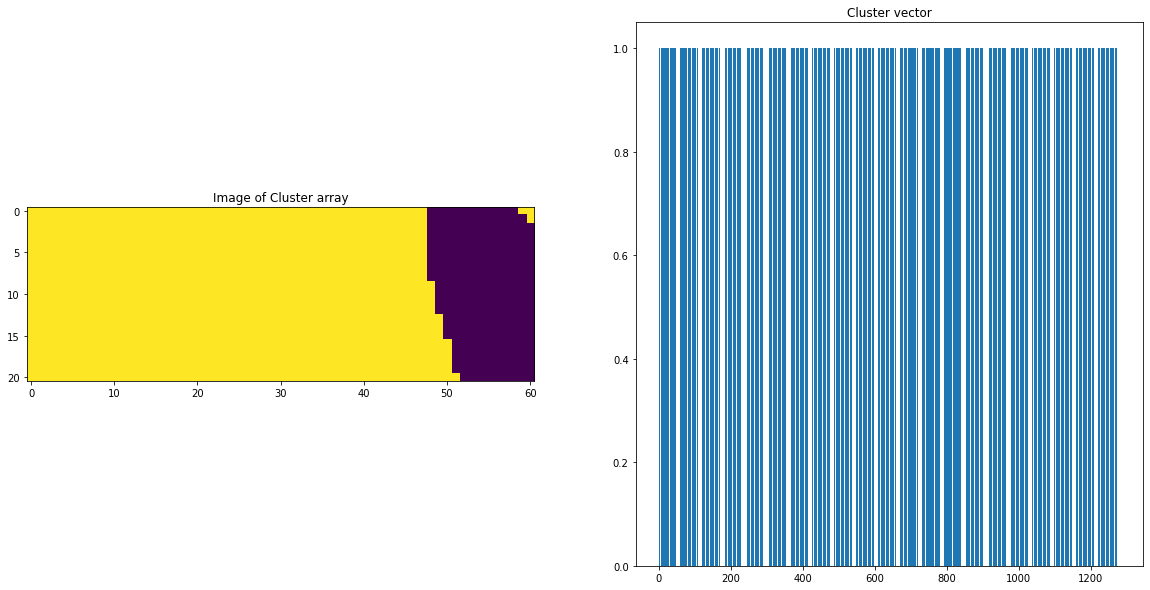

In [315]:
# View cluster_array Result
print(cluster_array)
fig2 = plt.figure(figsize=(20,10))

fig2.add_subplot(121)
plt.title('Image of Cluster array')
plt.imshow(cluster_array)

fig2.add_subplot(122)
plt.title('Cluster vector')
plt.bar(cluster_vector_idx, cluster_vector )

plt.show()

# 9.3 ROI: Region of Interest Drawing ROI bounding box

In [316]:
uq = np.unique(cluster_array)

* 9.3.1 K-MEAN CLUSTERING

In [328]:
# ReAssign Label in case of multiple ROIs with the same clusterID
all_labels = label(cluster_array)
# Define bounding box parameter
Color = (255,0,0)
Thickness = 2

In [329]:
# ROI bounding box
ROI_bb_img_list = []
nClass = np.unique(all_labels)
for i in nClass:
  img2 = cv2.imread('/content/drive/MyDrive/image_processing_lab9/Animals/Cats/cat10.jpg')
  img2 = cv2.resize(img2, (80,80), interpolation=cv2.INTER_AREA)
  img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
  #calculate from grid to actual position
  objPos = np.argwhere(all_labels == i)
  startBlockH = objPos[:,0].min()
  endBlockH = objPos[:,0].max()
  startBlockW = objPos[:,1].min()
  endBlockW = objPos[:,1].max()
  startF = (posCol[startBlockW], posRow[startBlockH])
  endF =(posCol[endBlockW]+Block_size[1], posRow[endBlockH]+Block_size[0])
  # draw regtangle boundary
  if i == 0:
    Color = (255,0,0)
  elif i ==1:
    Color = (0,255,0)
  elif i ==2:
    Color = (0,0,255)
  ROI_bounding_img = cv2.rectangle(img2, startF, endF, Color, Thickness)
  ROI_bb_img_list.append(ROI_bounding_img)

In [320]:
nClass

array([0, 1, 2])

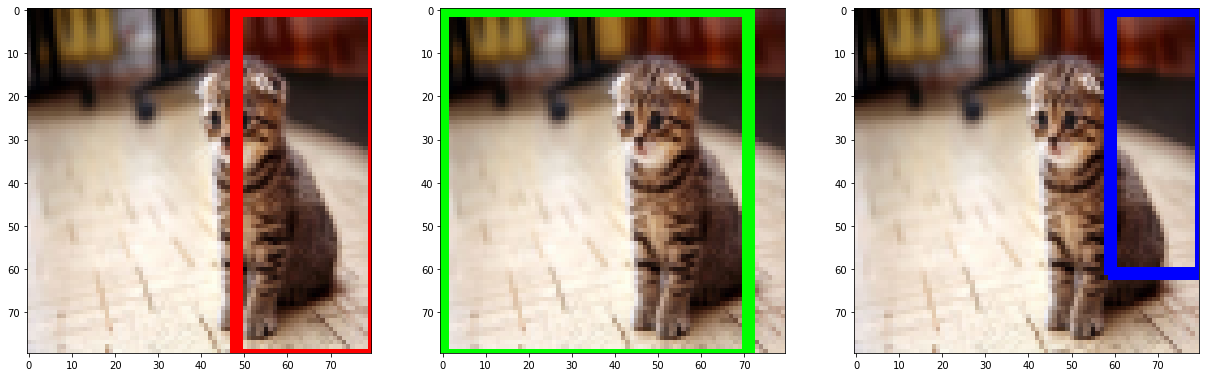

In [334]:
fig3 = plt.figure(figsize=(21,7))
for i in range(3):
  fig3.add_subplot(1,3,i+1)
  plt.imshow(ROI_bb_img_list[i])
plt.show()